<a href="https://colab.research.google.com/github/Syed-Osama-Hussain/Imagined-Speech-Prediction-from-EEG/blob/master/long_short_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.io
import os
from google.colab import drive
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.utils import shuffle
from keras.layers import LSTM, Dropout, GRU, Input, Reshape
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers.merge import concatenate
from keras.models import Model
import keras.backend as K


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls "drive/My Drive/dataset/Short_Long_words/"

sub_10_ch64_sl_eog_removed_256Hz_bw20.mat
sub_14_ch64_sl_eog_removed_256Hz_bw20.mat
sub_1c_ch64_sl_eog_removed_256Hz_bw20.mat
sub_5c_ch64_sl_eog_removed_256Hz_bw20.mat
sub_8d_ch64_sl_eog_removed_256Hz.mat
sub_9b_ch64_sl_eog_removed_256Hz_bw20.mat


In [19]:
mat = scipy.io.loadmat("drive/My Drive/dataset/Short_Long_words/sub_8d_ch64_sl_eog_removed_256Hz")
end_trial = mat['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
last_beep = mat['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']

Cooperate during speech imagery state

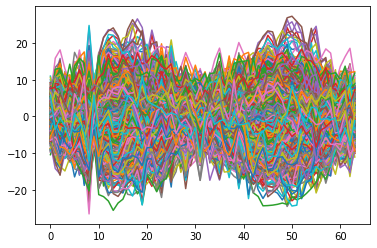

In [20]:
plt.plot(last_beep[0][0]);

"In" during Speech Imagery

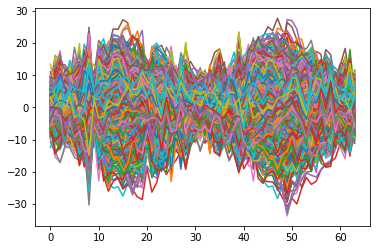

In [21]:
plt.plot(last_beep[1][0]);

C1 = Cooperate, C2 = In

In [6]:
def covariance(matrix):
  res_mat = np.cov(matrix,bias=True)
  return res_mat

In [7]:
def loadMatrices(dir):
  matrices_c1 = []
  matrices_c2 = []
  for root,sub,files in os.walk(dir):
    for f in sorted(files):
      mat_file  =  scipy.io.loadmat(os.path.join(root, f))
      end_trial = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
      last_beep = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
      matrices_c1.extend([covariance(matrix) for matrix in end_trial[0]])
      matrices_c1.extend([covariance(matrix) for matrix in last_beep[0]])
      matrices_c2.extend([covariance(matrix) for matrix in end_trial[1]])
      matrices_c2.extend([covariance(matrix) for matrix in last_beep[1]])
  return np.concatenate((np.array(matrices_c1),np.array(matrices_c2)),axis=0)

In [8]:
train_data = loadMatrices("drive/My Drive/dataset/Short_Long_words/")

In [9]:
print(train_data.shape)

(2240, 64, 64)


In [10]:
labels = np.concatenate((np.zeros(1120),np.ones(1120)),axis=0)
print(labels)

[0. 0. 0. ... 1. 1. 1.]


In [11]:
from keras.utils.np_utils import to_categorical
labels = to_categorical(labels, num_classes=2)
print(labels.shape,labels)

(2240, 2) [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [15]:
visible = Input(shape=(64,64))
#CNN
cov1 = Conv1D(filters=64, kernel_size=2, activation="relu")(visible)
cov2 = Conv1D(filters=64, kernel_size=4, activation="relu")(cov1)
newShape = Reshape((60,64), name='newReshape')(cov2)
f1 = Flatten()(newShape)
d1 = Dense(128, activation='relu')(f1)
d2 = Dense(128, activation='relu')(d1)

#RNN
gru1 = GRU(64,activation="relu",return_sequences=True)(visible)
gru2 = GRU(64,activation="relu")(gru1)
d3 = Dense(64, activation='relu')(gru2)
d4 = Dense(64, activation='relu')(d3)
#Merge
merge = concatenate([d2, d4])

#DAE
encoder1 = Dense(768, activation='relu')(merge)
encoder2 = Dense(96, activation='relu')(encoder1)
decoder1 = Dense(768, activation='relu')(encoder2)
decoder2 = Dense(192, activation='relu')(decoder1)

#FNN
hidden1 = Dense(64, activation='relu')(encoder2)
hidden2 = Dense(64, activation='relu')(hidden1)
output = Dense(2, activation='softmax')(hidden2)
model = Model(inputs=visible, outputs=output)
print(model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64)]     0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 63, 64)       8256        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 60, 64)       16448       conv1d_2[0][0]                   
__________________________________________________________________________________________________
newReshape (Reshape)            (None, 60, 64)       0           conv1d_3[0][0]                   
_______________________________________________________________________________________

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Iteration no  0  for training 
Epoch 1/200
56/56 [==============================] - 4s 67ms/step - loss: 0.6934 - accuracy: 0.4827 - val_loss: 0.6931 - val_accuracy: 0.5156
Epoch 2/200
56/56 [==============================] - 4s 65ms/step - loss: 0.6932 - accuracy: 0.4860 - val_loss: 0.6931 - val_accuracy: 0.5156
Epoch 3/200
56/56 [==============================] - 4s 66ms/step - loss: 0.6932 - accuracy: 0.4972 - val_loss: 0.6932 - val_accuracy: 0.4844
Epoch 4/200
56/56 [==============================] - 4s 67ms/step - loss: 0.6932 - accuracy: 0.4782 - val_loss: 0.6932 - val_accuracy: 0.4844
Epoch 5/200
56/56 [==============================] - 4s 66ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6934 - val_accuracy: 0.4844
Epoch 6/200
56/56 [==============================] - 4s 66ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6934 - val_accuracy: 0.4844
Epoch 7/200
56/56 [==============================] - 4s 68ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.693

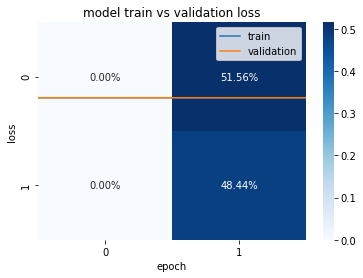

Iteration no  1  for training 
Epoch 1/200
56/56 [==============================] - 4s 66ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6931 - val_accuracy: 0.5089
Epoch 2/200
56/56 [==============================] - 4s 66ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6931 - val_accuracy: 0.5089
Epoch 3/200
56/56 [==============================] - 4s 65ms/step - loss: 0.6932 - accuracy: 0.4877 - val_loss: 0.6932 - val_accuracy: 0.4911
Epoch 4/200
56/56 [==============================] - 4s 65ms/step - loss: 0.6933 - accuracy: 0.4866 - val_loss: 0.6932 - val_accuracy: 0.4911
Epoch 5/200
56/56 [==============================] - 4s 66ms/step - loss: 0.6932 - accuracy: 0.4821 - val_loss: 0.6932 - val_accuracy: 0.4911
Epoch 6/200
56/56 [==============================] - 4s 65ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4911
Epoch 7/200
56/56 [==============================] - 4s 66ms/step - loss: 0.6932 - accuracy: 0.4877 - val_loss: 0.693

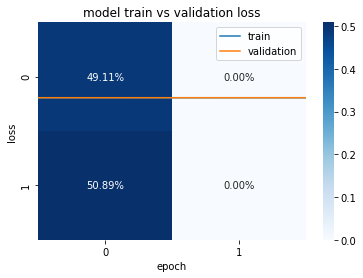

In [18]:
for i in range(2):
  print("Iteration no ",i," for training \n=========\n=========\n=========")

  train_data, labels = shuffle(train_data, labels)

  divide_percent=(len(train_data)*0.2)
  x_test=train_data[0:int(divide_percent)]
  y_test=labels[0:int(divide_percent)]
  x_train = train_data[int(divide_percent):len(train_data)]
  y_train = labels[int(divide_percent):len(labels)]
  history = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=200,verbose=1)
  predictions = model.predict(x_test,verbose=0)
  np.round(predictions)
  rounded_labels = np.argmax(y_test, axis=1)
  rounded_predictions = np.argmax(predictions, axis=1)
  cf = confusion_matrix(rounded_labels,rounded_predictions)  # doctest: +SKIP
  sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')
  print("Loss Comparison ====================================================")
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()